1. Prediction model

- Predict the current market value (adjusted for inflation) of football players based on performance indicators and demographics.

Prediction Variable: Annual Market value of a football (soccer) player based on personal demographic statictics (age, height, foot, position, etc.) and
performance metrices (minutes played, goals scored, assists, red and yellow cards, etc.)


add to read.me
- pip install xgboost


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb

from matplotlib import pyplot as plt

import plotly
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, MaxAbsScaler

from sklearn.feature_selection import SequentialFeatureSelector

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline


In [2]:
seed = 1


In [3]:
df = pd.read_csv("data/all_merged.csv")
# this should be change to all_merged.csv, which can be downloaded from google drive


In [4]:
df


,player_id,player_club_id,year,goals,assists,yellow_cards,red_cards,minutes_played,games_played,league_rank,...,assists_per_90,yellows_per_90,reds_per_90,minutes_per_game,country_of_citizenship,country_of_birth,position,foot,height_in_cm,age
0,10,398,2014,4,3,2,0,496,15,3.0,...,0.544355,0.362903,0.000000,33.066667,Germany,Poland,Attack,Right,184.0,36
1,10,398,2015,12,8,6,0,2429,36,3.0,...,0.296418,0.222314,0.000000,67.472222,Germany,Poland,Attack,Right,184.0,37
2,10,398,2016,8,5,1,0,1078,20,3.0,...,0.417440,0.083488,0.000000,53.900000,Germany,Poland,Attack,Right,184.0,38
3,132,11,2015,2,2,1,0,679,15,1.0,...,0.265096,0.132548,0.000000,45.266667,Czech Republic,CSSR,Attack,Both,179.0,35
4,215,1084,2014,5,1,0,0,985,13,2.0,...,0.091371,0.000000,0.000000,75.769231,Paraguay,Paraguay,Attack,Right,193.0,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44737,914562,273,2022,3,0,5,0,570,16,5.0,...,0.000000,0.789474,0.000000,35.625000,France,France,Attack,Right,181.0,17
44738,939763,7378,2022,2,1,3,0,885,13,6.0,...,0.101695,0.305085,0.000000,68.076923,Brazil,Brazil,Attack,Left,185.0,23
44739,946883,366,2022,0,0,0,0,602,8,2.0,...,0.000000,0.000000,0.000000,75.250000,Spain,Spain,Defender,Right,182.0,18
44740,962555,2282,2022,1,0,6,1,1106,14,9.0,...,0.000000,0.488246,0.081374,79.000000,Cote d'Ivoire,Cote d'Ivoire,Defender,Left,188.0,20


In [5]:
df.columns


Index(['player_id', 'player_club_id', 'year', 'goals', 'assists',
       'yellow_cards', 'red_cards', 'minutes_played', 'games_played',
       'league_rank', 'adjusted_price', 'CL_minutes_played', 'CL_games_played',
       'EL_minutes_played', 'EL_games_played', 'goals_per_90',
       'assists_per_90', 'yellows_per_90', 'reds_per_90', 'minutes_per_game',
       'country_of_citizenship', 'country_of_birth', 'position', 'foot',
       'height_in_cm', 'age'],
      dtype='object')

 We can hereby check what is in the column again.

<AxesSubplot:>

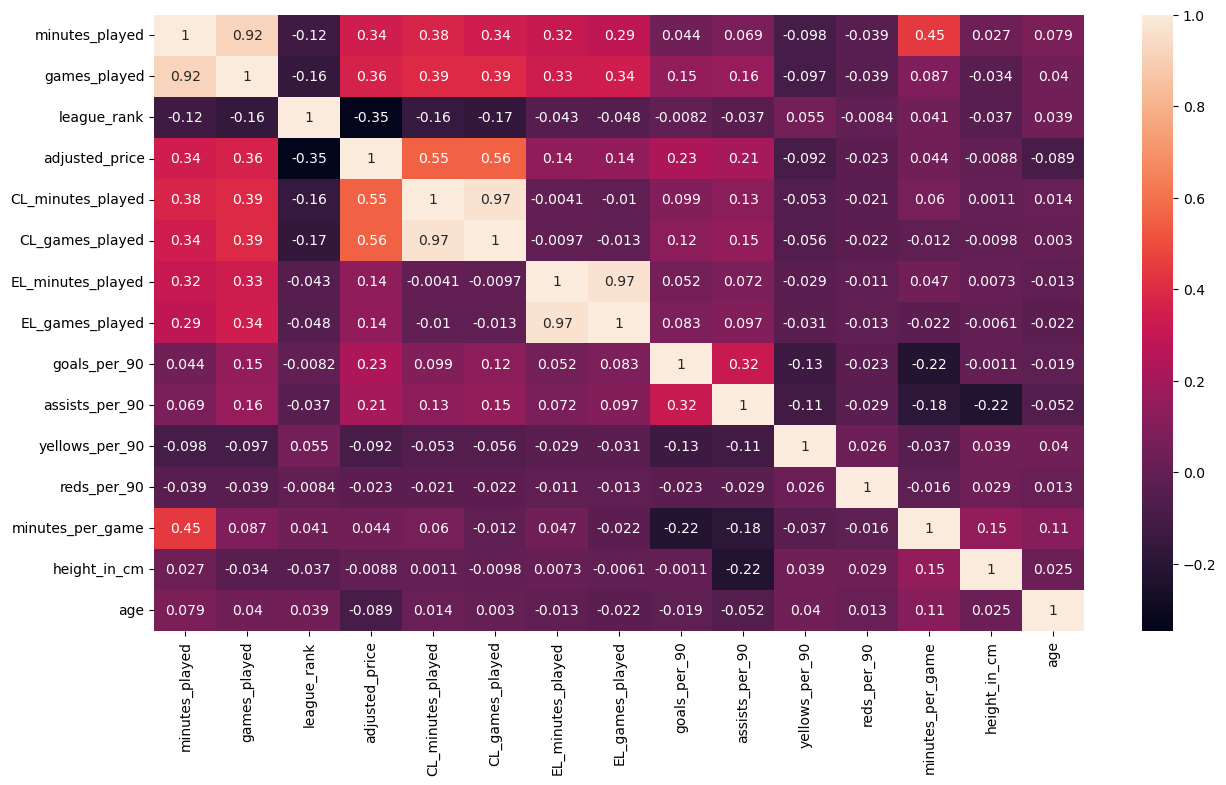

In [6]:

df_selected = df[['minutes_played', 'games_played', 'league_rank', 'adjusted_price', 'CL_minutes_played',
       'CL_games_played', 'EL_minutes_played', 'EL_games_played',
       'goals_per_90', 'assists_per_90', 'yellows_per_90', 'reds_per_90',
       'minutes_per_game', 'height_in_cm', 'age']]

fig, ax1 = plt.subplots(figsize=(15,8))
sns.heatmap(df_selected.corr(method='pearson'), annot = True)

To check if there is any insight that we can get from the correlation. But for this stage we decide to process with feature SFS.

### Feature Selection


In [7]:
#check whether the data type is appropriate for further engineering
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44742 entries, 0 to 44741
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   player_id               44742 non-null  int64  
 1   player_club_id          44742 non-null  int64  
 2   year                    44742 non-null  int64  
 3   goals                   44742 non-null  int64  
 4   assists                 44742 non-null  int64  
 5   yellow_cards            44742 non-null  int64  
 6   red_cards               44742 non-null  int64  
 7   minutes_played          44742 non-null  int64  
 8   games_played            44742 non-null  int64  
 9   league_rank             44742 non-null  float64
 10  adjusted_price          44742 non-null  float64
 11  CL_minutes_played       44742 non-null  int64  
 12  CL_games_played         44742 non-null  int64  
 13  EL_minutes_played       44742 non-null  int64  
 14  EL_games_played         44742 non-null

In [8]:
df["position"].unique()


array(['Attack', 'Midfield', 'Defender'], dtype=object)

Since there were still data (position and foot as) that comes in categorical data, we have to change it into binary data so it can be further processed. 

In [9]:
# apply one-hot encoding to postion
df_encoded = pd.get_dummies(df["position"], columns=['position'])


In [10]:
df_encoded


,Attack,Defender,Midfield
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
44737,1,0,0
44738,1,0,0
44739,0,1,0
44740,0,1,0


In [11]:
# merged the encoded data to the origin dataset
df = df.drop('position', axis=1)
df_merged = pd.concat([df, df_encoded], axis=1)



In [12]:
# apply one-hot encoding to foot

df_encoded = pd.get_dummies(df_merged["foot"], columns=['foot'])

# dropped the foot categorical data and have the encoded data merged to the origin dataset

df_merged = df_merged.drop('foot', axis=1)

df_encoded = pd.concat([df_merged, df_encoded], axis=1)


In [13]:
df_encoded


,player_id,player_club_id,year,goals,assists,yellow_cards,red_cards,minutes_played,games_played,league_rank,...,country_of_citizenship,country_of_birth,height_in_cm,age,Attack,Defender,Midfield,Both,Left,Right
0,10,398,2014,4,3,2,0,496,15,3.0,...,Germany,Poland,184.0,36,1,0,0,0,0,1
1,10,398,2015,12,8,6,0,2429,36,3.0,...,Germany,Poland,184.0,37,1,0,0,0,0,1
2,10,398,2016,8,5,1,0,1078,20,3.0,...,Germany,Poland,184.0,38,1,0,0,0,0,1
3,132,11,2015,2,2,1,0,679,15,1.0,...,Czech Republic,CSSR,179.0,35,1,0,0,1,0,0
4,215,1084,2014,5,1,0,0,985,13,2.0,...,Paraguay,Paraguay,193.0,33,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44737,914562,273,2022,3,0,5,0,570,16,5.0,...,France,France,181.0,17,1,0,0,0,0,1
44738,939763,7378,2022,2,1,3,0,885,13,6.0,...,Brazil,Brazil,185.0,23,1,0,0,0,1,0
44739,946883,366,2022,0,0,0,0,602,8,2.0,...,Spain,Spain,182.0,18,0,1,0,0,0,1
44740,962555,2282,2022,1,0,6,1,1106,14,9.0,...,Cote d'Ivoire,Cote d'Ivoire,188.0,20,0,1,0,0,1,0


This is the merged dataset that has the foot and poisition encoded.

In [14]:
#Seperating the data into set of features X and target y

X = df_encoded.drop(['player_id', 'player_club_id', 'year', 'adjusted_price', 'country_of_citizenship', 'country_of_birth'], axis = 1)    
y = df_encoded['adjusted_price']

In [15]:
X.describe()


,goals,assists,yellow_cards,red_cards,minutes_played,games_played,league_rank,CL_minutes_played,CL_games_played,EL_minutes_played,...,reds_per_90,minutes_per_game,height_in_cm,age,Attack,Defender,Midfield,Both,Left,Right
count,44742.000000,44742.000000,44742.000000,44742.000000,44742.000000,44742.000000,44742.000000,44742.000000,44742.000000,44742.000000,...,44742.000000,44742.000000,44742.000000,44742.000000,44742.000000,44742.000000,44742.000000,44742.000000,44742.000000,44742.000000
mean,2.224778,1.687385,3.267243,0.074069,1440.493876,20.018528,7.439453,38.294175,0.546086,45.658777,...,0.005093,71.325427,181.648120,26.491574,0.349560,0.397568,0.252872,0.042399,0.252537,0.705065
std,3.572744,2.357370,2.705077,0.274390,803.577089,9.592590,5.154001,129.548378,1.731634,130.350687,...,0.021502,15.094949,6.357122,4.054413,0.476836,0.489401,0.434663,0.201499,0.434472,0.456019
min,0.000000,0.000000,0.000000,0.000000,451.000000,5.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,16.333333,151.525773,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,817.000000,13.000000,3.000000,0.000000,0.000000,0.000000,...,0.000000,61.166667,177.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,3.000000,0.000000,1236.000000,17.000000,6.000000,0.000000,0.000000,0.000000,...,0.000000,74.769231,182.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,3.000000,2.000000,5.000000,0.000000,1837.750000,26.000000,11.000000,0.000000,0.000000,0.000000,...,0.000000,84.000000,186.000000,29.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,58.000000,32.000000,23.000000,3.000000,5070.000000,59.000000,20.000000,1230.000000,13.000000,1324.000000,...,0.361446,98.571429,202.000000,44.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


This could help check the data overview distribution.

In [16]:
#Splitting the data into test and train

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = seed)
y_test


26009    9.724539e+06
36947    2.039554e+06
22831    8.107486e+07
844      2.330919e+05
40885    1.900848e+05
             ...     
24510    6.609334e+05
15013    2.173555e+06
23342    4.881390e+06
24462    3.382789e+07
41850    1.051791e+06
Name: adjusted_price, Length: 11186, dtype: float64

### Feature engineering

In [17]:
X.columns

Index(['goals', 'assists', 'yellow_cards', 'red_cards', 'minutes_played',
       'games_played', 'league_rank', 'CL_minutes_played', 'CL_games_played',
       'EL_minutes_played', 'EL_games_played', 'goals_per_90',
       'assists_per_90', 'yellows_per_90', 'reds_per_90', 'minutes_per_game',
       'height_in_cm', 'age', 'Attack', 'Defender', 'Midfield', 'Both', 'Left',
       'Right'],
      dtype='object')

These are the columns in X.

In [18]:
#SFS

X_column =  ['goals', 'assists', 'yellow_cards', 'red_cards', 'minutes_played',
       'games_played', 'league_rank', 'CL_minutes_played', 'CL_games_played',
       'EL_minutes_played', 'EL_games_played', 'goals_per_90',
       'assists_per_90', 'yellows_per_90', 'reds_per_90', 'minutes_per_game',
       'height_in_cm', 'age', 'Attack', 'Defender', 'Midfield', 'Both', 'Left',
       'Right']

In [19]:
len(X_column)


24

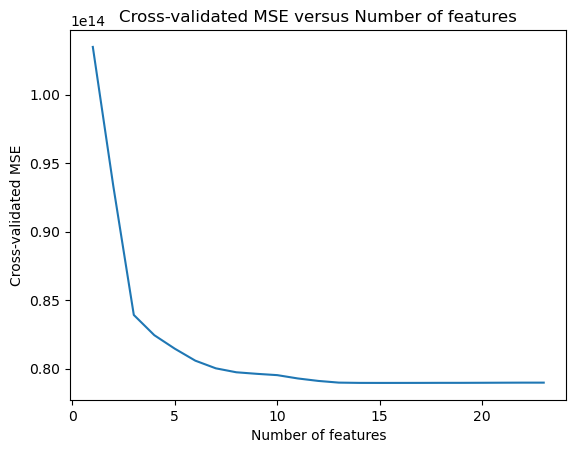

In [20]:
# trying to do the iteration of how many features to select 

mse_scores = []

model = LinearRegression()


for k in range(1, 24):
    sfs = SequentialFeatureSelector(model, 
                                    n_features_to_select=k, 
                                    direction='forward',
                                    scoring='neg_mean_squared_error',
                                    cv=10)
    sfs = sfs.fit(X_train, y_train)
    X_train_sfs = sfs.transform(X_train)
    scores = cross_val_score(model, X_train_sfs, y_train, cv=10, scoring='neg_mean_squared_error')
    mse_scores.append(-scores.mean())

# plot it to see which number of features reach decent MSE
plt.plot(range(1, 24), mse_scores)
plt.xlabel('Number of features')
plt.ylabel('Cross-validated MSE')
plt.title('Cross-validated MSE versus Number of features')

plt.show()


We use the mse scores to see at what amount of features is considered taking good care of the model. We found that at 10 features reaches a pretty steady MSE. That is to say, adding more feature upon this point does not necessarily decrease the cross-validate MSE.

In [21]:
# Taking ten as our n_features_to_select; fit this into our model and get the selected features

sfs = SequentialFeatureSelector(model, 
                                n_features_to_select = 10, 
                                direction = 'forward',
                                scoring = 'neg_mean_squared_error',
                                cv = 10) 
sfs = sfs.fit(X_train, y_train)
feature_names = np.array(X_column)
feature_names
print("Features selected by SFS: "+str(feature_names[sfs.get_support()]))

Features selected by SFS: ['goals' 'assists' 'games_played' 'league_rank' 'CL_minutes_played'
 'CL_games_played' 'EL_minutes_played' 'minutes_per_game' 'age' 'Midfield']


These are the selected features thtough SFS.

In [22]:
# transform the X,y into the dataset with the selected features only 
selected = feature_names[sfs.get_support()].tolist()

X_train_selected = sfs.transform(X_train)
X_test_selected = sfs.transform(X_test)



X_train_selected


array([[13.        ,  4.        , 37.        , ..., 58.40540541,
        32.        ,  0.        ],
       [ 1.        ,  0.        , 16.        , ..., 87.9375    ,
        29.        ,  0.        ],
       [ 4.        ,  3.        , 42.        , ..., 84.47619048,
        30.        ,  1.        ],
       ...,
       [ 1.        ,  0.        ,  9.        , ..., 93.33333333,
        35.        ,  0.        ],
       [ 0.        ,  0.        , 33.        , ..., 89.54545455,
        32.        ,  0.        ],
       [ 0.        ,  0.        , 12.        , ..., 54.33333333,
        19.        ,  1.        ]])

We applied (transformed) it into the X that would be used to train and test.

In [23]:
# to provide overview of the selected feature (size = 0.75*origin datasize)

X_train_selected_df = pd.DataFrame(X_train_selected, columns=selected)
X_test_selected_df = pd.DataFrame(X_test_selected, columns=selected)
X_train_selected_df


,goals,assists,games_played,league_rank,CL_minutes_played,CL_games_played,EL_minutes_played,minutes_per_game,age,Midfield
0,13.0,4.0,37.0,2.0,700.0,10.0,0.0,58.405405,32.0,0.0
1,1.0,0.0,16.0,1.0,0.0,0.0,0.0,87.937500,29.0,0.0
2,4.0,3.0,42.0,13.0,0.0,0.0,872.0,84.476190,30.0,1.0
3,0.0,0.0,16.0,3.0,0.0,0.0,0.0,77.312500,33.0,1.0
4,1.0,0.0,9.0,20.0,0.0,0.0,0.0,68.888889,24.0,0.0
...,...,...,...,...,...,...,...,...,...,...
33551,2.0,0.0,12.0,11.0,0.0,0.0,0.0,68.250000,22.0,1.0
33552,0.0,0.0,22.0,2.0,0.0,0.0,294.0,56.136364,24.0,0.0
33553,1.0,0.0,9.0,20.0,0.0,0.0,0.0,93.333333,35.0,0.0
33554,0.0,0.0,33.0,20.0,0.0,0.0,0.0,89.545455,32.0,0.0


In [24]:
# LinearRegression() does not require scaling

model = LinearRegression()

cross_val = KFold(n_splits=10, random_state=None, shuffle=False)
reg = model.fit(X_train_selected, y_train)

rsquared_train = reg.score(X_train_selected, y_train)
rsquared_test = reg.score(X_test_selected, y_test)


scores = cross_val_score(model, X_train_selected, y_train, scoring="neg_mean_squared_error", cv=cross_val)

y_train_pred = reg.predict(X_train_selected)
y_test_pred = reg.predict(X_test_selected)

print('Training MSE:', mean_squared_error(y_train, y_train_pred))
print('Testing MSE:', mean_squared_error(y_test, y_test_pred))

print("R-squared Train: "+str(rsquared_train))
print("R-squared Test: "+str(rsquared_test))


Training MSE: 79337077690886.73
Testing MSE: 77118751483409.72
R-squared Train: 0.46961076694679693
R-squared Test: 0.4859306377789774


Since Linear Regression does not require scaling, so we just worked it out and find that R-squared Test at 0.4859, which is not bad.

In [25]:
# PolynomialFeatures

cross_val = KFold(n_splits=10, shuffle=True)

for degree in range(1, 5):
    poly_features = PolynomialFeatures(degree=degree)
    X_poly_train = poly_features.fit_transform(X_train_selected)
    X_poly_test = poly_features.transform(X_test_selected)

    lm_poly = LinearRegression()
    lm_poly.fit(X_poly_train, y_train)

    y_train_pred_poly = lm_poly.predict(X_poly_train)
    y_test_pred_poly = lm_poly.predict(X_poly_test)

    scores = cross_val_score(lm_poly, X_poly_train, y_train, scoring="neg_mean_squared_error", cv=cross_val)

    print("Degree: ", degree)

    print('Training MSE:', mean_squared_error(y_train, y_train_pred_poly))
    print('Testing MSE:', mean_squared_error(y_test, y_test_pred_poly))

    print("Training R-squared:", lm_poly.score(X_poly_train, y_train))
    print("Testing R-squared:", lm_poly.score(X_poly_test, y_test))

    print()

Degree:  1
Training MSE: 79337077690886.75
Testing MSE: 77118751483409.69
Training R-squared: 0.4696107669467968
Testing R-squared: 0.4859306377789776

Degree:  2
Training MSE: 57627131030506.09
Testing MSE: 57017918559948.39
Training R-squared: 0.6147474709187899
Testing R-squared: 0.6199216861597081

Degree:  3
Training MSE: 49111194845065.695
Testing MSE: 52749101598593.016
Training R-squared: 0.6716787443357912
Testing R-squared: 0.6483773855914388

Degree:  4
Training MSE: 42984802779836.16
Testing MSE: 63939232188532.234
Training R-squared: 0.7126352867675725
Testing R-squared: 0.5737845896126614



At degree of 3, it reaches the Testing R-squared at 0.6483773855914388, which is pretty good.

In [26]:
# best Polynomial = 3
poly_features = PolynomialFeatures(degree=3)
X_poly_train = poly_features.fit_transform(X_train_selected)
X_poly_test = poly_features.transform(X_test_selected)

lm_poly = LinearRegression()
lm_poly.fit(X_poly_train, y_train)

y_train_pred_poly = lm_poly.predict(X_poly_train)
y_test_pred_poly = lm_poly.predict(X_poly_test)

scores = cross_val_score(lm_poly, X_poly_train, y_train, scoring="neg_mean_squared_error", cv=cross_val)

print("Degree: ", 3)

print('Training MSE:', mean_squared_error(y_train, y_train_pred_poly))
print('Testing MSE:', mean_squared_error(y_test, y_test_pred_poly))

print("Training R-squared:", lm_poly.score(X_poly_train, y_train))
print("Testing R-squared:", lm_poly.score(X_poly_test, y_test))

print()

Degree:  3
Training MSE: 49111194845065.695
Testing MSE: 52749101598593.016
Training R-squared: 0.6716787443357912
Testing R-squared: 0.6483773855914388



In [27]:
param_grid = {'max_depth': [3,4,5,6,7,8,9,10]}

tree_model = DecisionTreeRegressor(random_state=seed)

grid_search = GridSearchCV(tree_model, param_grid, scoring='neg_mean_squared_error', cv=10)

grid_search.fit(X_train_selected, y_train)

print("Best max_depth value: ", grid_search.best_params_)
print("Training MSE with best max_depth value: ", abs(grid_search.best_score_))


Best max_depth value:  {'max_depth': 7}
Training MSE with best max_depth value:  68171351934100.45


Since DecisionTreeRegressor does not require scaling as well, we search through which parameter ('max_depth') works best with the model, it goes by {'max_depth': 7}.

In [28]:
model = DecisionTreeRegressor(max_depth=grid_search.best_params_['max_depth'], random_state=seed)

model.fit(X_train_selected, y_train)

scores = cross_val_score(model, X_train_selected, y_train, scoring='neg_mean_squared_error', cv=10)

y_train_pred = model.predict(X_train_selected)
y_test_pred = model.predict(X_test_selected)

print('Training MSE:', mean_squared_error(y_train, y_train_pred))
print('Testing MSE:', mean_squared_error(y_test, y_test_pred))                             
print("Training R-squared: ", model.score(X_train_selected, y_train))
print("Testing R-squared: ", model.score(X_test_selected, y_test))


Training MSE: 51918921555372.28
Testing MSE: 61204671105526.07
Training R-squared:  0.6529083527377457
Testing R-squared:  0.5920130236167807


When applied the best parameter back to the Decision Tree Regressor, it final Testing R-squared is at 0.5920130236167807, which is okay.

In [29]:
#  RandomForestRegressor() does not require scaling as well

param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3,5,7,9],
    'max_features': ['sqrt', 'log2']
}

rf_model = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(rf_model, param_grid, scoring='neg_mean_squared_error', cv=10)

grid_search.fit(X_train_selected, y_train)

print("Best hyperparameters: ", grid_search.best_params_)
print("Training MSE with best hyperparameters: ", abs(grid_search.best_score_))

# Best hyperparameters:  {'max_depth': 9, 'max_features': 'sqrt', 'n_estimators': 500}
# Training MSE with best hyperparameters:  53419781029287.45

Best hyperparameters:  {'max_depth': 9, 'max_features': 'sqrt', 'n_estimators': 500}
Training MSE with best hyperparameters:  53419781029287.45


Since Random Forest Regressor does not require scaling as well, we search through which parameter{'n_estimators','max_depth','max_features'} works best with the model.

It turned out to be the best hyperparameters is  {'max_depth': 9, 'max_features': 'sqrt', 'n_estimators': 500}
with best Training MSE at 53419781029287.45

In [30]:
# apply best_parameter to the model

model = RandomForestRegressor(n_estimators=grid_search.best_params_['n_estimators'], 
                               max_depth=grid_search.best_params_['max_depth'], 
                               max_features=grid_search.best_params_['max_features'],
                               random_state=42)

model.fit(X_train_selected, y_train)

scores = cross_val_score(model, X_train_selected, y_train, scoring='neg_mean_squared_error', cv=10)

y_train_pred = model.predict(X_train_selected)
y_test_pred = model.predict(X_test_selected)

print('Training MSE:', mean_squared_error(y_train, y_train_pred))
print('Testing MSE:', mean_squared_error(y_test, y_test_pred))                             
print("Training R-squared: ", model.score(X_train_selected, y_train))
print("Testing R-squared: ", model.score(X_test_selected, y_test))

Training MSE: 39702721998524.586
Testing MSE: 51278113964524.7
Training R-squared:  0.7345768601035723
Testing R-squared:  0.6581829083772062


Having the best parameter back to the Random Forest Regressor , it final Testing R-squared is at 0.6581829083772062.

In [31]:
# XGBoost eXtreme Gradient Boosting
# Bagging + Boosting 
# does not require scaling
cross_val = KFold(n_splits=10, random_state=None, shuffle=False)

model = xgb.XGBRegressor()

model.fit(X_train_selected, y_train)

rsquared_train = model.score(X_train_selected, y_train)
rsquared_test = model.score(X_test_selected, y_test)

scores = cross_val_score(model, X_train_selected, y_train, scoring="neg_mean_squared_error", cv=cross_val)

y_train_pred = model.predict(X_train_selected)
y_test_pred = model.predict(X_test_selected)

print('Training MSE:',mean_squared_error(y_train, y_train_pred))
print('Testing MSE:', mean_squared_error(y_test, y_test_pred))
print("R-squared Train: "+str(rsquared_train))
print("R-squared Test: "+str(rsquared_test))

Training MSE: 21345341079028.234
Testing MSE: 50691270912746.78
R-squared Train: 0.8573007802445782
R-squared Test: 0.6620947719324171


This is the new model that we tried using with or prediction model and this also does not require scaling. This model's testing R-squared is at 0.662094771932417, which is so far the working the best at having R-squared Test: 0.6620947719324171!

In [32]:
# ridge
# do the scaling and search for parameter that works best with the model


scalers = [RobustScaler(), StandardScaler(), MinMaxScaler(), MaxAbsScaler()]

param_grid = {
    'scaler': scalers,
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
}

# model, scaler, alpha 
best_model = None
best_scaler = None
best_alpha = None

#mse 
best_mse = float('inf')


# do the scale, and inside each scale loop through the alpha
for scaler in scalers:

    X_train_scaled = scaler.fit_transform(X_train_selected)
    X_test_scaled = scaler.transform(X_test_selected)
    
    for alpha in param_grid['alpha']:
        model = Ridge(alpha=alpha)
        model.fit(X_train_scaled, y_train)
        
        y_train_pred = model.predict(X_train_scaled)
        y_test_pred = model.predict(X_test_scaled)
        
        mse_train = mean_squared_error(y_train, y_train_pred)
        mse_test = mean_squared_error(y_test, y_test_pred)
        

        # update the best model 
        if mse_test < best_mse:
            best_model = model
            best_scaler = scaler
            best_alpha = alpha
            best_mse = mse_test



y_train_pred_best = best_model.predict(best_scaler.transform(X_train_selected))
y_test_pred_best = best_model.predict(best_scaler.transform(X_test_selected))

mse_train_best = mean_squared_error(y_train, y_train_pred_best)
mse_test_best = mean_squared_error(y_test, y_test_pred_best)

print("Best Scaler:", best_scaler)
print("Best Alpha:", best_alpha)
print("Best Training MSE:", mse_train_best)
print("Best Testing MSE:", mse_test_best)

print("Training R-squared: ", r2_score(y_train, y_train_pred_best))
print("Testing R-squared: ", r2_score(y_test, y_test_pred_best))


Best Scaler: RobustScaler()
Best Alpha: 100.0
Best Training MSE: 79337967276423.03
Best Testing MSE: 77114038180465.47
Training R-squared:  0.46960481983349167
Testing R-squared:  0.48596205639756107


Through the Ridge model, we have been working on different scaler, and use the update model to reach the best scaler as well as parameter {'alpha'}, it has Testing R-squared of 0.48596205639756107.

In [33]:
#lasso

scalers = [RobustScaler(), StandardScaler(), MinMaxScaler(), MaxAbsScaler()]

param_grid = {
    'scaler': scalers,
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]  
}

# model, scaler, alpha 
best_model = None
best_scaler = None
best_alpha = None

#mse
best_mse = float('inf')


# do the scale, and inside each scale loop through the alpha
for scaler in scalers:

    X_train_scaled = scaler.fit_transform(X_train_selected)
    X_test_scaled = scaler.transform(X_test_selected)
    
    for alpha in param_grid['alpha']:
        model = Lasso(alpha=alpha)
        model.fit(X_train_scaled, y_train)
        
        y_train_pred = model.predict(X_train_scaled)
        y_test_pred = model.predict(X_test_scaled)
        
        mse_train = mean_squared_error(y_train, y_train_pred)
        mse_test = mean_squared_error(y_test, y_test_pred)
        

        # update the best model 
        if mse_test < best_mse:
            best_model = model
            best_scaler = scaler
            best_alpha = alpha
            best_mse = mse_test



y_train_pred_best = best_model.predict(best_scaler.transform(X_train_selected))
y_test_pred_best = best_model.predict(best_scaler.transform(X_test_selected))

mse_train_best = mean_squared_error(y_train, y_train_pred_best)
mse_test_best = mean_squared_error(y_test, y_test_pred_best)

print("Best Scaler:", best_scaler)
print("Best Alpha:", best_alpha)
print("Best Training MSE:", mse_train_best)
print("Best Testing MSE:", mse_test_best)

print("Training R-squared: ", r2_score(y_train, y_train_pred_best))
print("Testing R-squared: ", r2_score(y_test, y_test_pred_best))


Best Scaler: StandardScaler()
Best Alpha: 100.0
Best Training MSE: 79337078419326.61
Best Testing MSE: 77118708271844.56
Training R-squared:  0.4696107620769847
Testing R-squared:  0.4859309258248977


Through the Lasso model, we have been working on different scaler, and use the update model to reach the best scaler as well as parameter {'alpha'}, it has Testing R-squared of 0.4859309258248977, which is not bad, but we've got better model!


Overall, the best model would be XGBoost (eXtreme Gradient Boosting), reaching R-squared Test: 0.662!

## Additional

In [34]:
# This is to answer the origin question that we had, which in fact is using groupby  
# On average, are market values of left-footed players higher than those of right-footed players?


selected_features = ['adjusted_price','Right', 'Left', 'Both']

X_new_selected = df_encoded[selected_features]

grouped_data_new_right = X_new_selected[X_new_selected['Right'] == 1].groupby('Right')['adjusted_price'].mean()
print("Average Adjusted Price for Right-footed players:", grouped_data_new_right)

grouped_data_new_left = X_new_selected[X_new_selected['Left'] == 1].groupby('Left')['adjusted_price'].mean()
print("Average Adjusted Price for Left-footed players:", grouped_data_new_left)

grouped_data_new_both = X_new_selected[X_new_selected['Both'] == 1].groupby('Both')['adjusted_price'].mean()
print("Average Adjusted Price for players with Both feet:", grouped_data_new_both)


Average Adjusted Price for Right-footed players: Right
1    6.296582e+06
Name: adjusted_price, dtype: float64
Average Adjusted Price for Left-footed players: Left
1    6.281020e+06
Name: adjusted_price, dtype: float64
Average Adjusted Price for players with Both feet: Both
1    5.927265e+06
Name: adjusted_price, dtype: float64


We can observe that on average Right-footed players have better market value.

### Reference

- Lab2_S23_Marisa_Yang for correlationmap
- https://datagy.io/seaborn-legend/ 
- https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html poly
- https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html standard scaler
- Lab; slides; in-class excercise; answer key; mideterm for module, model
- https://xgboost.readthedocs.io/en/stable/
- https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html